In [1]:
import sys
sys.path.insert(0, '../')

from src.power.gen_scen_fnctns import *

In [2]:
import datetime
import os
import pandapower.networks as nw
import pandas as pd
import numpy as np
import pandapower.plotting as plot
import pandapower as pp
from pygit2 import Repository
import sys
import copy
import random
from pandapower.estimation import estimate,remove_bad_data
import time

## Select your base Power Grid from Pandapower for your research
<span style="color:red">(Note: Power grid shall match the one used to generate the measurements template)</span>

In [3]:
net=nw.case118() #Select Power grid here

## Select Parameters

In [4]:
input_params = {
    'set_id': 'A', # Enter prefix for scenario id (Note: Prefix enables you to combine runs easily)
    'n_clean_scenarios':500,  # Enter No. of load scenarios
    'noise_per_clean': 10,  # Enter No. of noisy scenarios per clean scenaios. No of overall generated examples will be n_clean_scenarios x noise_per_clean
    'inst_error':0.02, # Enter value to be used for all meas except voltage magnitudes whereas inst error will be 0.5 x inst_error
    'noise_on_meas': 'gaussian' #noise imposed on measurments to generate noisy scenarios either gaussian or uniform. In both cases, inst_error std dev is used
}


#### Construct Paths

In [5]:
runs_path = '../runs/'

currentDT = datetime.datetime.now()
trial = 'Power_' + input_params['set_id'] + '_' + str(currentDT.year) + str(currentDT.month) + str(
    currentDT.day) + str(
    currentDT.hour) + str(currentDT.minute)


if not os.path.exists(runs_path + trial):
    os.makedirs(runs_path + trial)
trial_path = runs_path + trial + "/"

if not os.path.exists(runs_path + trial + '/grid'):
    os.makedirs(runs_path + trial + '/grid')
grid_path = runs_path + trial + "/grid/"


if not os.path.exists(runs_path + trial + '/datasets'):
    os.makedirs(runs_path + trial + '/datasets')
datasets_path = runs_path + trial + "/datasets/"

if not os.path.exists(runs_path + trial + '/base_net'):
    os.makedirs(runs_path + trial + '/base_net')
base_net_path = runs_path + trial + '/base_net/'

In [6]:
net_label='case'+str(len(net.bus))
n_bus = len(net.bus)
slack=net.ext_grid.bus.item()
inst_err=input_params['inst_error']

In [7]:
"""Run AC power flow analysis for base network"""
pp.runpp(net)

#### Construct Measurements

In [8]:
h4all = gen_h4all(net) 

In [9]:
all_meas = pd.read_csv('../runs/meas_template.csv')#Template shall correspond to grid. Manually construct the template if necessary.

In [10]:
"""Construct measurments for base network based on meas template"""
h,h_reordered, h_no_slack=gen_meas(net, all_meas, h4all, base_net_path, inst_err=input_params['inst_error'])
n_meas=len(h)

Generating measurements for net..
Done!


#### Save Base Grid Info

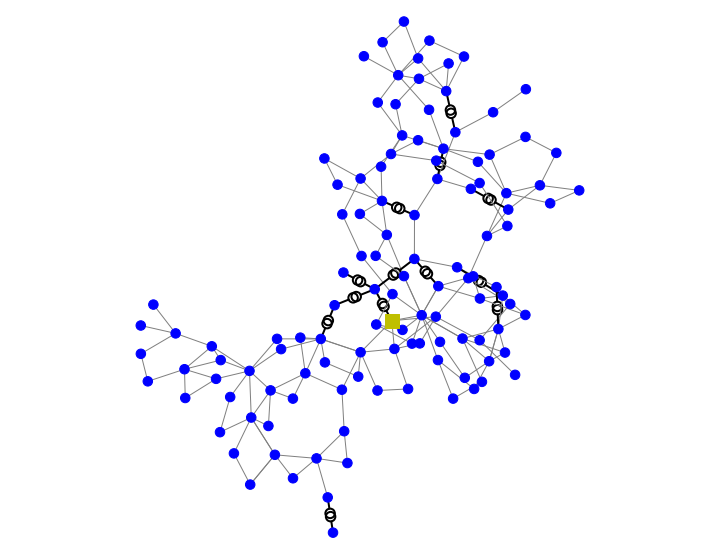

In [11]:
""" Save base network information"""
net.bus.to_csv(grid_path + 'grid_bus.csv')
net.line.to_csv(grid_path + 'grid_line.csv')
net.trafo.to_csv(grid_path + 'grid_trafo.csv')
net.trafo3w.to_csv(grid_path + 'grid_trafo3w.csv')
net.gen.to_csv(grid_path + 'grid_gen.csv')
net.load.to_csv(grid_path + 'grid_load.csv')

"""Plot base network"""
# simple plot of net with existing geocoordinates or generated artificial geocoordinates
net_ax=plot.simple_plot(net, show_plot=False)
net_fig=net_ax.get_figure()
net_fig.savefig(grid_path+'grid_plot.png')

## Generate Duplicated Clean Scenarios

In [12]:
""" Generate Clean Scenarios"""
clean_scenarios_ids,clean_scenarios=gen_clean_scen_unfrm(net, input_params['n_clean_scenarios'],input_params['set_id']) #clean_scenario which fails to converge using runpp will NOT be counted
dplct_ids, dplct_clean_scenarios = duplicate_scenarios(clean_scenarios_ids,clean_scenarios, input_params['noise_per_clean']) #this will creat new duplicate objects (i.e. nets) using deep copy

gen_clean_scen_unfrm: Generating BASE CLEAN scenario 0 ... 


Generating CLEAN scenario No.   1... 
Running Power Flow Analysis for net   1
Updating measurements of net   1
Generating CLEAN scenario No.   2... 
Running Power Flow Analysis for net   2
Updating measurements of net   2
Generating CLEAN scenario No.   3... 
Running Power Flow Analysis for net   3
Updating measurements of net   3
Generating CLEAN scenario No.   4... 
Running Power Flow Analysis for net   4
Updating measurements of net   4
Generating CLEAN scenario No.   5... 
Running Power Flow Analysis for net   5
Updating measurements of net   5
Generating CLEAN scenario No.   6... 
Running Power Flow Analysis for net   6
Updating measurements of net   6
Generating CLEAN scenario No.   7... 
Running Power Flow Analysis for net   7
Updating measurements of net   7
Generating CLEAN scenario No.   8... 
Running Power Flow Analysis for net   8
Updating measurements of net   8
Generating CLEAN scenario No.   9... 
Running Powe

#### Convert clean scenarios to featured Measurments dataset

In [13]:
"""Generate meas features for clean scenarios (same functions are used for both ac and dc since meas piker will decide what measurements) """
source_clean_meas = meas2features(clean_scenarios_ids,clean_scenarios ) #make sure to add this right after duplicate scenarios before being impacted by adding noise
dplct_source_clean_meas = meas2features(dplct_ids,dplct_clean_scenarios ) #make sure to add this right after duplicate scenarios before being impacted by adding noise
dplct_source_clean_meas.to_csv(datasets_path + 'source_clean_meas.csv', index=False)


Convert measurements to features..
Done!
Convert measurements to features..
Done!


#### Convert clean scenarios to featured States dataset

In [14]:
""" Generate states features both pfa-based and wls-based states for Clean scenarios"""
dplct_target_clean_states=pf_states2features(dplct_ids, dplct_clean_scenarios) #this is duplicated GT for ac
dplct_target_clean_states=dplct_target_clean_states.drop(columns=['va_'+str(slack)],axis=1)
dplct_target_clean_states.to_csv(datasets_path + 'target_gt_states.csv', index=False)


Convert estimated states to features..
Done!


## Add noise to clean scenarios

In [15]:
""" Generate Noisy  Scenarios"""
noisy_scenarios_ids,noisy_scenarios = gen_noisy_meas(input_params,dplct_ids,dplct_clean_scenarios) #Note: noise passed thru run_hp either gaussian or uniform. Note2:  changes made by this line will impact dplct_clean_scenarios since both  noisy_scenarios and dplct_clean_scenarios point to same objects
source_noisy_meas = meas2features(noisy_scenarios_ids,noisy_scenarios) #make sure to add this right after duplicate scenarios before being impacted by adding noise
source_noisy_meas.to_csv(datasets_path + 'source_noisy_meas.csv', index=False)



Add noise to measurements..
Convert measurements to features..
Done!
